In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import wfdb
# import datetime

In [2]:
# read files
record = wfdb.rdrecord('data/sleep-heart-health-study-psg-database-1.0.0/0000')
ann = wfdb.rdann('data/sleep-heart-health-study-psg-database-1.0.0/0000', extension='resp')

In [3]:
record.__dict__

{'record_name': '0000',
 'n_sig': 11,
 'fs': 1,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 32399,
 'base_time': datetime.time(21, 30),
 'base_date': None,
 'comments': ['<age>: 47  <sex>: F  <BMI>: 29.73215'],
 'sig_name': ['SaO2',
  'PR',
  'EEG(sec)',
  'ECG',
  'EMG',
  'EOG(L)',
  'EOG(R)',
  'EEG',
  'AIRFLOW',
  'THOR RES',
  'ABDO RES'],
 'p_signal': array([[ 9.60111600e+01,  6.72646286e+01,  9.80392157e-01, ...,
         -3.98431373e+00,  1.56862745e+00,  2.82352941e-01],
        [ 9.60111600e+01,  6.72646286e+01,  3.92156863e+00, ...,
         -3.98431373e+00,  1.28627451e+00, -6.58823529e-01],
        [ 9.60111600e+01,  6.92627085e+01,  2.94117647e+00, ...,
         -3.98431373e+00, -5.33333333e-01, -3.76470588e+00],
        ...,
        [ 9.40130850e+01,  6.12825724e+01, -1.96078431e+00, ...,
         -8.47058824e-01,  6.27450980e-02, -1.56862745e-01],
        [ 9.40130850e+01,  6.12825724e+01,  4.90196078e+00, ...,
         -2.19607843e-01,  2.82352941e-01, -

Data consists of 9 hours of data with 1 sample per second (9\*60\*60 = 32400)

In [4]:
signals = record.p_signal
sig_names = record.sig_name

In [5]:
signals.shape

(32399, 11)

In [6]:
units = dict(zip(record.sig_name, record.units))
units

{'SaO2': '%',
 'PR': 'BPM',
 'EEG(sec)': 'uV',
 'ECG': 'mV',
 'EMG': 'uV',
 'EOG(L)': 'uV',
 'EOG(R)': 'uV',
 'EEG': 'uV',
 'AIRFLOW': 'V',
 'THOR RES': 'V',
 'ABDO RES': 'V'}

In [7]:
df = pd.DataFrame(signals, columns = sig_names)

In [8]:
df.head(3)

,SaO2,PR,EEG(sec),ECG,EMG,EOG(L),EOG(R),EEG,AIRFLOW,THOR RES,ABDO RES
0,96.01116,67.264629,0.980392,-0.266667,-0.000000,-38.235294,29.411765,-11.764706,-3.984314,1.568627,0.282353
1,96.01116,67.264629,3.921569,-0.211765,-1.458825,-17.647059,17.647059,-2.941176,-3.984314,1.286275,-0.658824
2,96.01116,69.262709,2.941176,-0.250980,-0.000000,14.705882,9.803922,2.941176,-3.984314,-0.533333,-3.764706


Let's take a look at the raw signals

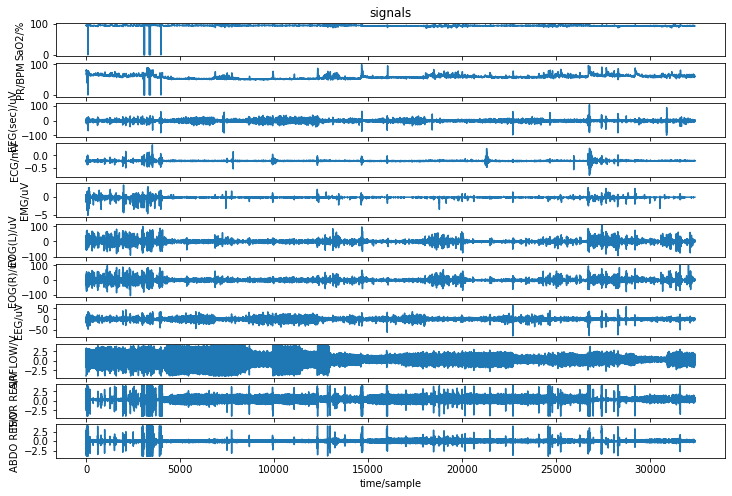

In [9]:
# plot signals
wfdb.plot_wfdb(record=record, title='signals', figsize=(12, 8))

There seems to be outliers in a couple of our signals caused by error (SaO2 and PR). We might drop those later.

In [10]:
df.SaO2.describe()

count    32399.000000
mean        95.008177
std          3.142611
min          0.201026
25%         94.013085
50%         95.012122
75%         96.011160
max         99.008273
Name: SaO2, dtype: float64

In [11]:
df.PR.describe()

count    32399.000000
mean        59.233140
std          6.147322
min          0.402053
25%         54.289293
50%         58.285453
75%         62.281612
max         99.209540
Name: PR, dtype: float64

In [75]:
# respiratory annotations
notes = pd.Series(ann.aux_note).str.split().to_list()
resp = pd.DataFrame(notes, ann.sample, columns=['type', 'duration', '% decrease', 'min SaO2'])
resp.head()

,type,duration,% decrease,min SaO2
1227,Hyp,0:10.8,2,94
4328,Hyp,0:19.2,2,94
4392,Hyp,0:19.3,2,94
4538,Hyp,0:16.7,2,96
5466,Hyp,0:15.2,3,95


In [74]:
resp.type.value_counts()

Hyp     208
Ob.A      6
Cn.A      3
Name: type, dtype: int64

Mostly hypopnea, but a few obstructive apneas and central apneas

### Cleaning Data

In [14]:
df.SaO2[df.SaO2<10].value_counts()

0.201026    29
Name: SaO2, dtype: int64

In [15]:
df.PR[df.PR<10].value_counts()

0.402053    29
Name: PR, dtype: int64

All of them are the same value, so this is probably the default reading when there is no proper measurement. To clean these, we will replace each of these with the mean values of the points directly before and after it. This may affect our measurements, so it will be important to keep our data imputation in mind when considering our analysis and results.

In [16]:
# set to null, then interpolate
df.SaO2[df.SaO2<10] = np.nan
df.SaO2 = df.SaO2.interpolate()
df.PR[df.PR<10] = np.nan
df.PR = df.PR.interpolate()

### Visualization

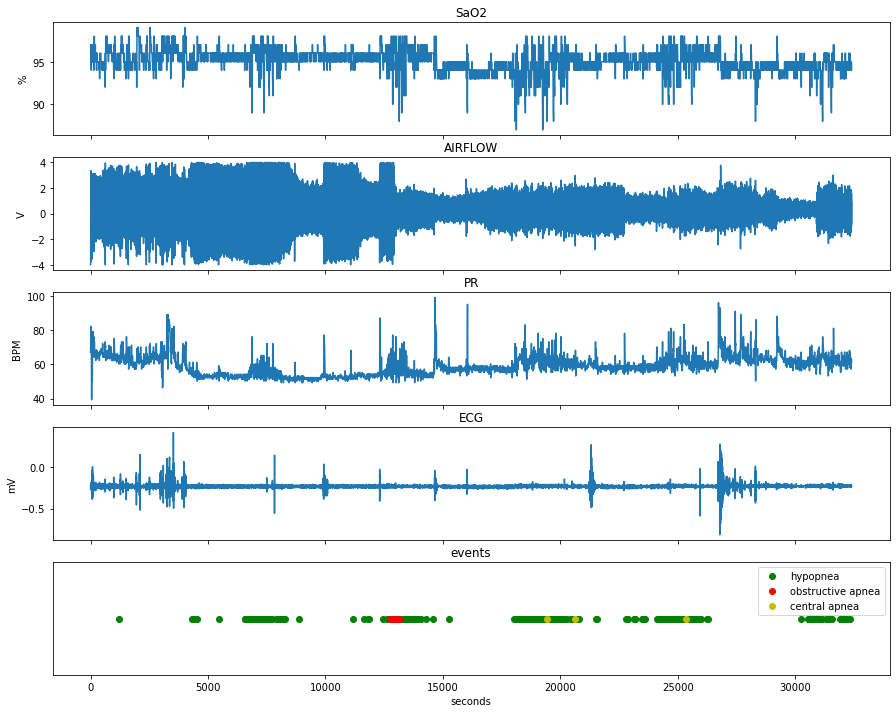

In [17]:
sigs = ['SaO2', 'AIRFLOW', 'PR', 'ECG']
events = ['Hyp', 'Ob.A', 'Cn.A']
event_colors = dict(zip(events, ['go', 'ro', 'yo']))

fig, axs = plt.subplots(len(sigs)+1, 1, figsize=(15,12), sharey='row', sharex=True)

# plot signals
for i, signal in enumerate(sigs):
    axs[i].set_title(signal)
    axs[i].plot(df[signal])
    axs[i].set_ylabel(units[signal])


# plot events
for event in events:
    plt.plot(resp[resp.type == event].index, np.zeros(resp[resp.type == event].shape[0]), event_colors[event])
plt.title('events')
plt.legend(['hypopnea', 'obstructive apnea', 'central apnea'])
plt.yticks([])

plt.xlabel('seconds')
plt.show()

### Analysis

In [18]:
import pywt

Let's take a look at a spectrogram of a sample of the ECG signal

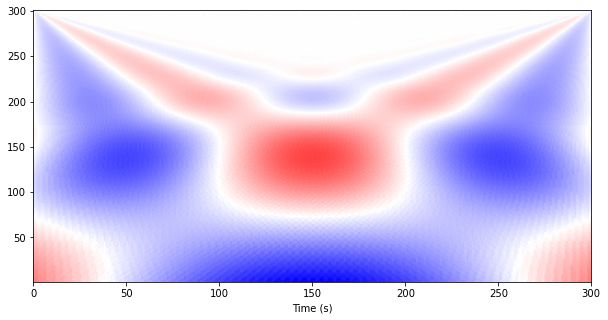

In [128]:
sample_len = 300
offset = 5000
# pywt.scale2frequency("morl", 1)/1
cwtmatr, freqs = pywt.cwt(
    df.ECG.values[offset:offset+sample_len], 
    scales=np.arange(1, sample_len+1), 
    wavelet = "morl",
    method= 'conv'
)
plt.figure(figsize=(10, 5))
plt.imshow(cwtmatr, extent=[0, sample_len, 1, sample_len+1], cmap='bwr', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

plt.xlabel('Time (s)')
# plt.imshow(cwtmatr, extent=[-1, 1, 1, 30], cmap='PRGn', aspect='auto',
#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

Lets take a look at the ECG signal during an obstructive apnea.

In [76]:
resp[resp.type == 'Ob.A']

,type,duration,% decrease,min SaO2
12751,Ob.A,0:15.1,2,95
12792,Ob.A,0:16.7,3,95
12833,Ob.A,0:15.0,6,90
12970,Ob.A,0:12.1,3,92
13010,Ob.A,0:15.1,6,92
13111,Ob.A,0:18.8,10,88


In [34]:
# timestamp for start point of obstructive event
start = min(resp[resp.type == 'Ob.A'].index)
# duration of event
dur = max(resp[resp.type == 'Ob.A'].index)
dur = end-start

In [78]:
start = 12751
dur = 15+1

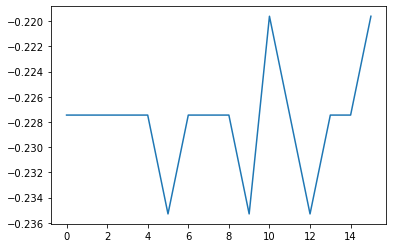

In [79]:
plt.plot(df.ECG.values[start:start+dur])

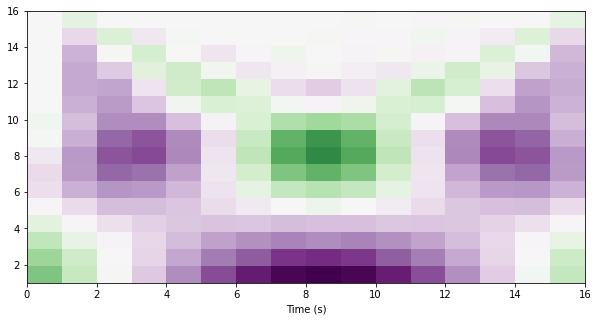

In [96]:
sample_len = dur
# pywt.scale2frequency("morl", 1)/1
cwtmatr, freqs = pywt.cwt(df.ECG.values[start:start+dur], scales=np.arange(1, sample_len+1), wavelet = "morl")
plt.figure(figsize=(10, 5))
plt.imshow(cwtmatr, extent=[0, sample_len, 1, sample_len], cmap='PRGn', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

plt.xlabel('Time (s)')
# plt.imshow(cwtmatr, extent=[-1, 1, 1, 30], cmap='PRGn', aspect='auto',
#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

We will need a much higher sample rate in order to learn anything meaningful from this. This problem will be solved when we get access to the original dataset.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def main_eda(file, outdir, signals, events, colors, **kwargs):
    
    os.makedirs(outdir, exist_ok = True)
    
    # read file
    record = wfdb.rdrecord(file)
    ann = wfdb.rdann(file, extension='resp')
    df = pd.DataFrame(record.p_signal, columns = record.sig_name)
    units = dict(zip(record.sig_name, record.units))
    notes = pd.Series(ann.aux_note).str.split().to_list()
    resp = pd.DataFrame(notes, ann.sample, columns=['type', 'duration', '% decrease', 'min SaO2'])
    
    # clean data
    df.SaO2[df.SaO2<10] = np.nan
    df.SaO2 = df.SaO2.interpolate()
    df.PR[df.PR<10] = np.nan
    df.PR = df.PR.interpolate()
    
    event_colors = dict(zip(events, colors))

    fig, axs = plt.subplots(len(signals)+1, 1, figsize=(15,12), sharey='row', sharex=True)

    # plot signals
    for i, signal in enumerate(signals):
        axs[i].set_title(signal)
        axs[i].plot(df[signal])
        axs[i].set_ylabel(units[signal])


    # plot events
    for event in events:
        plt.plot(resp[resp.type == event].index, np.zeros(resp[resp.type == event].shape[0]), event_colors[event])
    plt.title('events')
    plt.legend(events)
    plt.yticks([])
    plt.xlabel('seconds')
    
    plt.savefig(os.path.join(outdir, 'eda.png'))
    plt.close()
    
    sample_len = 300
    offset = 5000
    
    cwtmatr, freqs = pywt.cwt(
        df.ECG.values[offset:offset+sample_len], 
        scales=np.arange(1, sample_len+1), 
        wavelet = "morl",
        method= 'conv'
    )
    plt.figure(figsize=(10, 5))
    plt.imshow(cwtmatr, extent=[0, sample_len, 1, sample_len+1], cmap='bwr', aspect='auto',
                vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    plt.title('ECG cwt')
    plt.xlabel('Time (s)')